In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "03_image_models/03d_squeezenet.ipynb"
_nb_title = "Flowers Image Classification using SqueezeNet"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using SqueezeNet&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F03_image_models%2F03d_squeezenet.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F03_image_models%2F03d_squeezenet.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03d_squeezenet.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03d_squeezenet.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/03_image_models/03d_squeezenet.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Flowers Image Classification with SqueezeNet
In this notebook, we use SqueezeNet to classify the tf-flowers dataset.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.1
Found GPU at: /device:GPU:0


In [3]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(model, filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://cloud-ml-data/img/flower_photos/*"),
                 "gs://cloud-ml-data/img/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## SqueezeNet


In [8]:
def squeeze_module(x, n1, n2, prefix):
    squeeze = tf.keras.layers.Conv2D(filters=n1, kernel_size=(1, 1),
                                     padding='same', activation='relu',
                                     name=prefix+'_squeeze')(x)
    expand1 = tf.keras.layers.Conv2D(filters=n2, kernel_size=(1, 1),
                                     padding='same', activation='relu',
                                     name=prefix+'_expand1')(squeeze)
    expand2 = tf.keras.layers.Conv2D(filters=n2, kernel_size=(3, 3),
                                     padding='same', activation='relu',
                                     name=prefix+'_expand2')(squeeze)
    return tf.keras.layers.Concatenate(axis=0, 
                                       name=prefix+'_merge')([expand1, expand2])
    
    
def create_model():
    img = tf.keras.Input([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], name='image_input')
    conv1 = tf.keras.layers.Conv2D(filters=96, 
                                   kernel_size=(7, 7), 
                                   strides=(2, 2), 
                                   padding='valid', 
                                   activation='relu',
                                   name='conv1')(img)
    maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                         strides=(2, 2),
                                         name='maxpool1')(conv1)

    merge2 = squeeze_module(maxpool1, 16, 64, 'fire2')
    merge3 = squeeze_module(merge2, 16, 64, 'fire3')
    merge4 = squeeze_module(merge3, 32, 128, 'fire4')
    
    maxpool4 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                         strides=(2, 2),
                                         name='maxpool4')(merge4)
    
    merge5 = squeeze_module(maxpool4, 32, 128, 'fire5')
    merge6 = squeeze_module(merge5, 48, 192, 'fire6')
    merge7 = squeeze_module(merge6, 48, 192, 'fire7')
    merge8 = squeeze_module(merge7, 64, 256, 'fire8')
    
    maxpool8 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                         strides=(2, 2),
                                         name='maxpool8')(merge8)
    
    merge9 = squeeze_module(maxpool8, 64, 256, 'fire9')
    
    dropout9 = tf.keras.layers.Dropout(0.5, name='dropout9')(merge9)
    conv10 = tf.keras.layers.Conv2D(filters=len(CLASS_NAMES), 
                                   kernel_size=(1, 1), 
                                   padding='valid', 
                                   activation='relu',
                                   name='conv10')(dropout9)
    
    # the size of this layer has to match output of conv10
    avgpool10 = tf.keras.layers.AveragePooling2D(pool_size=(12, 12),
                                                 padding='valid',
                                                 name='avgpool10')(conv10)
    
    flatten = tf.keras.layers.Flatten(name='flatten')(avgpool10)
    out = tf.keras.activations.softmax(flatten)
    
    return tf.keras.Model(img, out, name='flower_classification')

In [9]:
import os

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32):
    train_dataset = (tf.data.TextLineDataset(
        "gs://cloud-ml-data/img/flower_photos/train_set.csv").
        map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
        "gs://cloud-ml-data/img/flower_photos/eval_set.csv").
        map(decode_csv)).batch(32) # this doesn't matter

    # covered in Ch 6
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = create_model()

        model.compile(optimizer='Adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(
                          from_logits=False),
                      metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=5)
    training_plot(['loss', 'accuracy'], history)
    return model

In [10]:
model = train_and_evaluate()

Model: "flower_classification"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 109, 109, 96) 14208       image_input[0][0]                
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 54, 54, 96)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2_squeeze (Conv2D)          (None, 54, 54, 16)   1552        maxpool1[0][0]                   
______________________________________________________________________________

ResourceExhaustedError:  OOM when allocating tensor with shape[8192,12,12,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node flower_classification/dropout9/dropout/random_uniform/RandomUniform (defined at <ipython-input-9-cdab59678da1>:20) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_6307]

Function call stack:
train_function


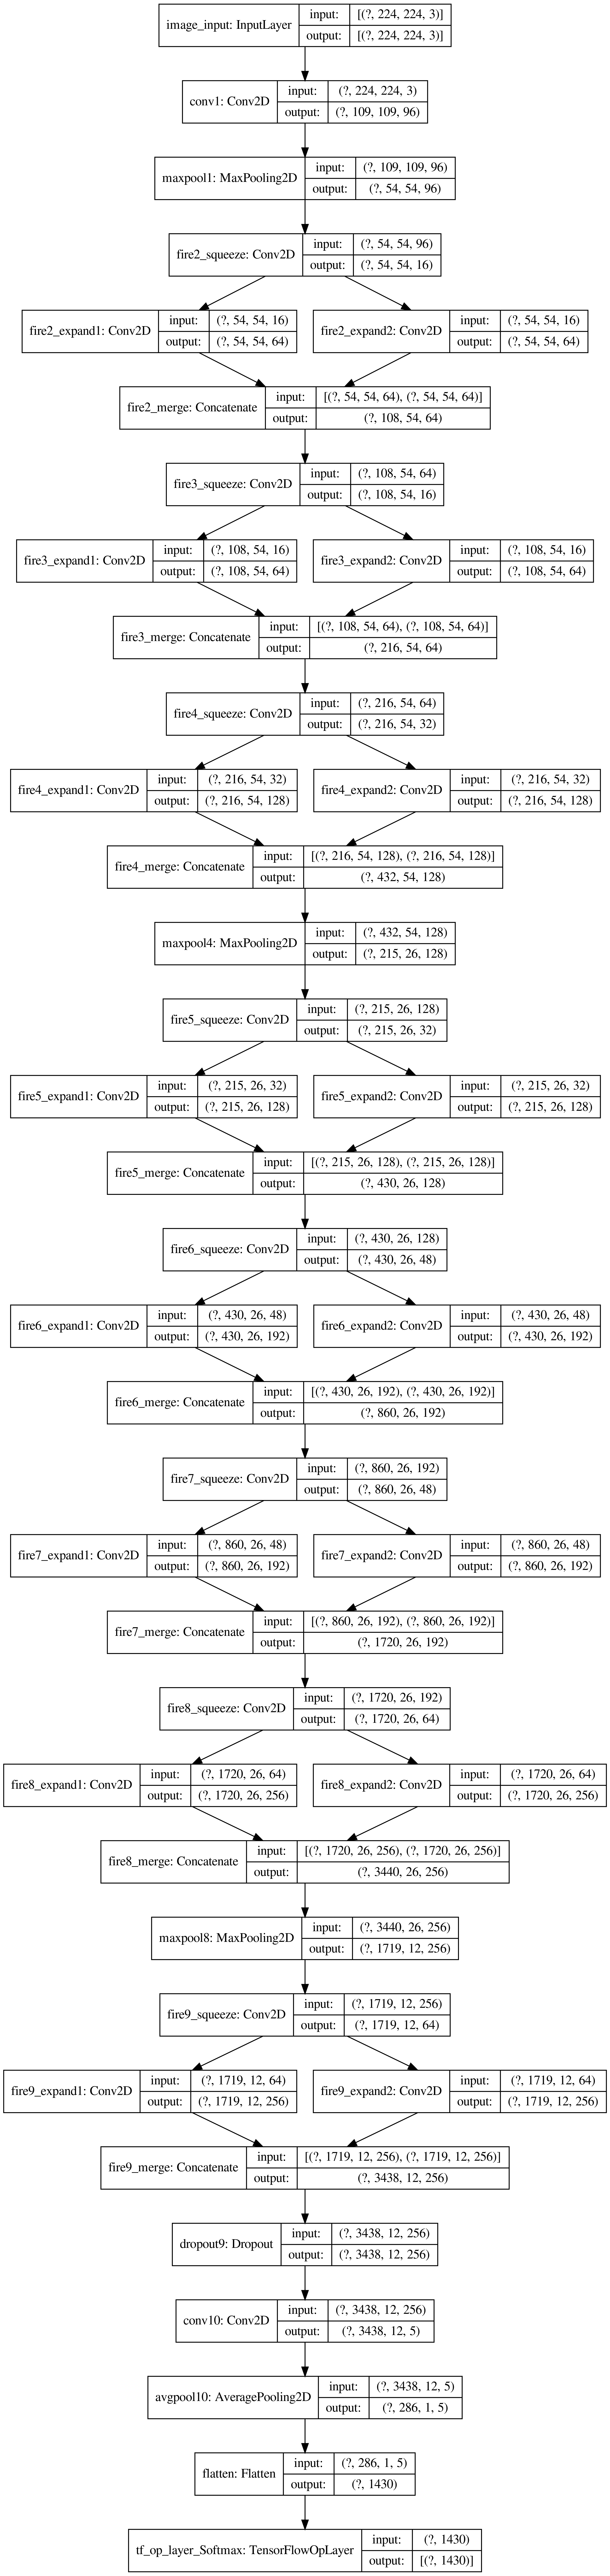

In [39]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, to_file='squeezenet.png', dpi=300)

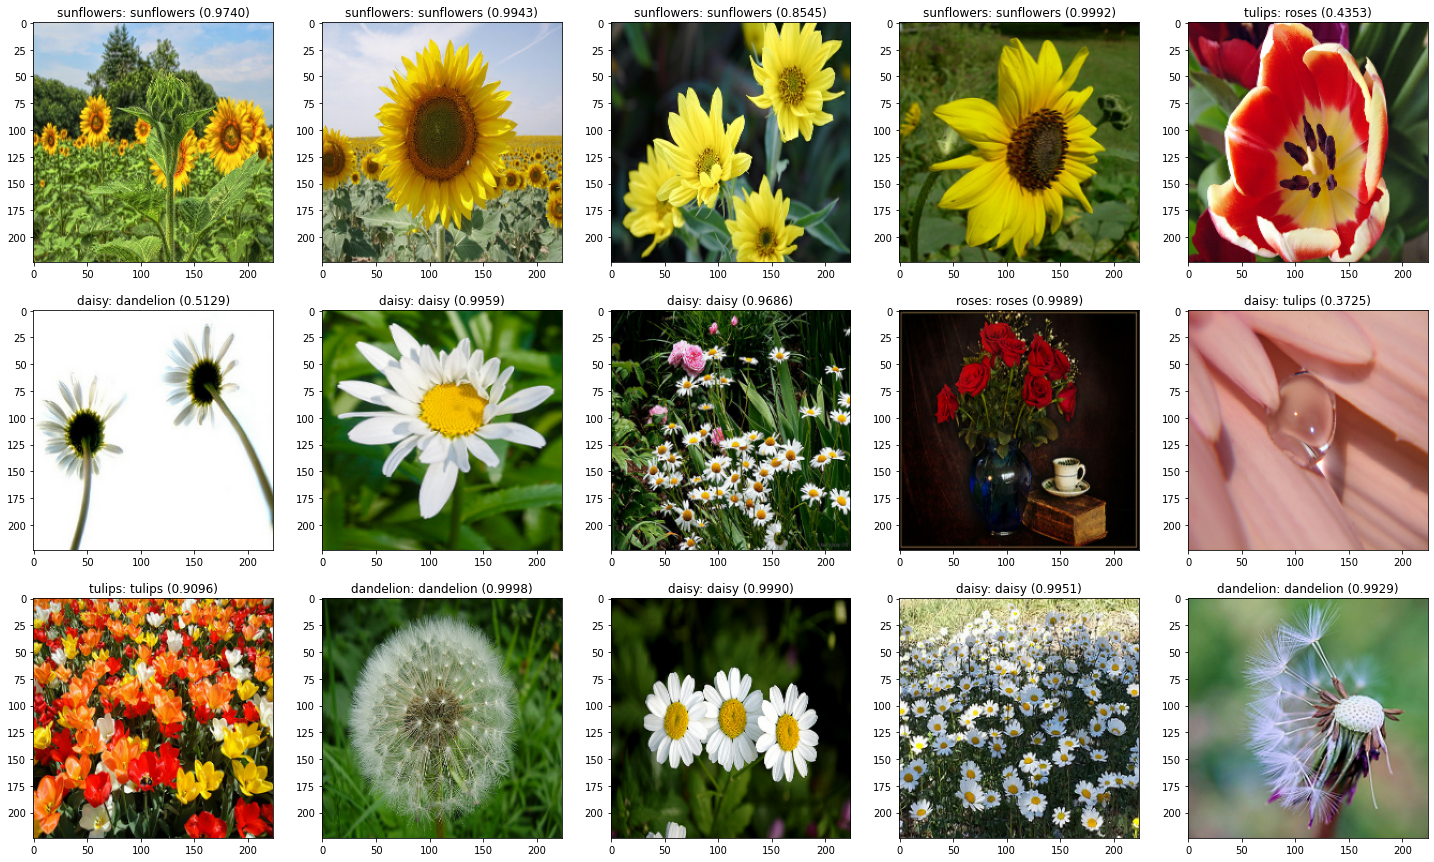

In [ ]:
plot_predictions(model, "gs://cloud-ml-data/img/flower_photos/eval_set.csv")

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.